In [2]:
import sys
import pandas as pd
import plotly.express as px
pd.set_option('mode.chained_assignment', None) #Avoids warning
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import gc
import multiprocessing 
from imblearn.under_sampling import RandomUnderSampler
import optuna.integration.lightgbm as olgb
import lightgbm as lgb
import sklearn
from sklearn.model_selection import train_test_split
from nancorrmp.nancorrmp import NaNCorrMp
from sklearn.feature_selection import SelectPercentile, mutual_info_classif
import joblib
from verstack import LGBMTuner

<font size ="7"> Feature Selection</font> 

The 4 practical ways of feature selection which yield best results are as follows:-

SelectKBeion
Correlation-matrix with heatmap
Random-Forest Impor
Recursive Feature Eliminationtance

In [3]:
train = pd.read_parquet("train.parquet")

<font size ="5"> Correlation matrix selection </font> 

In [5]:
corr_matrix = NaNCorrMp.calculate(X = train, n_jobs = -1)

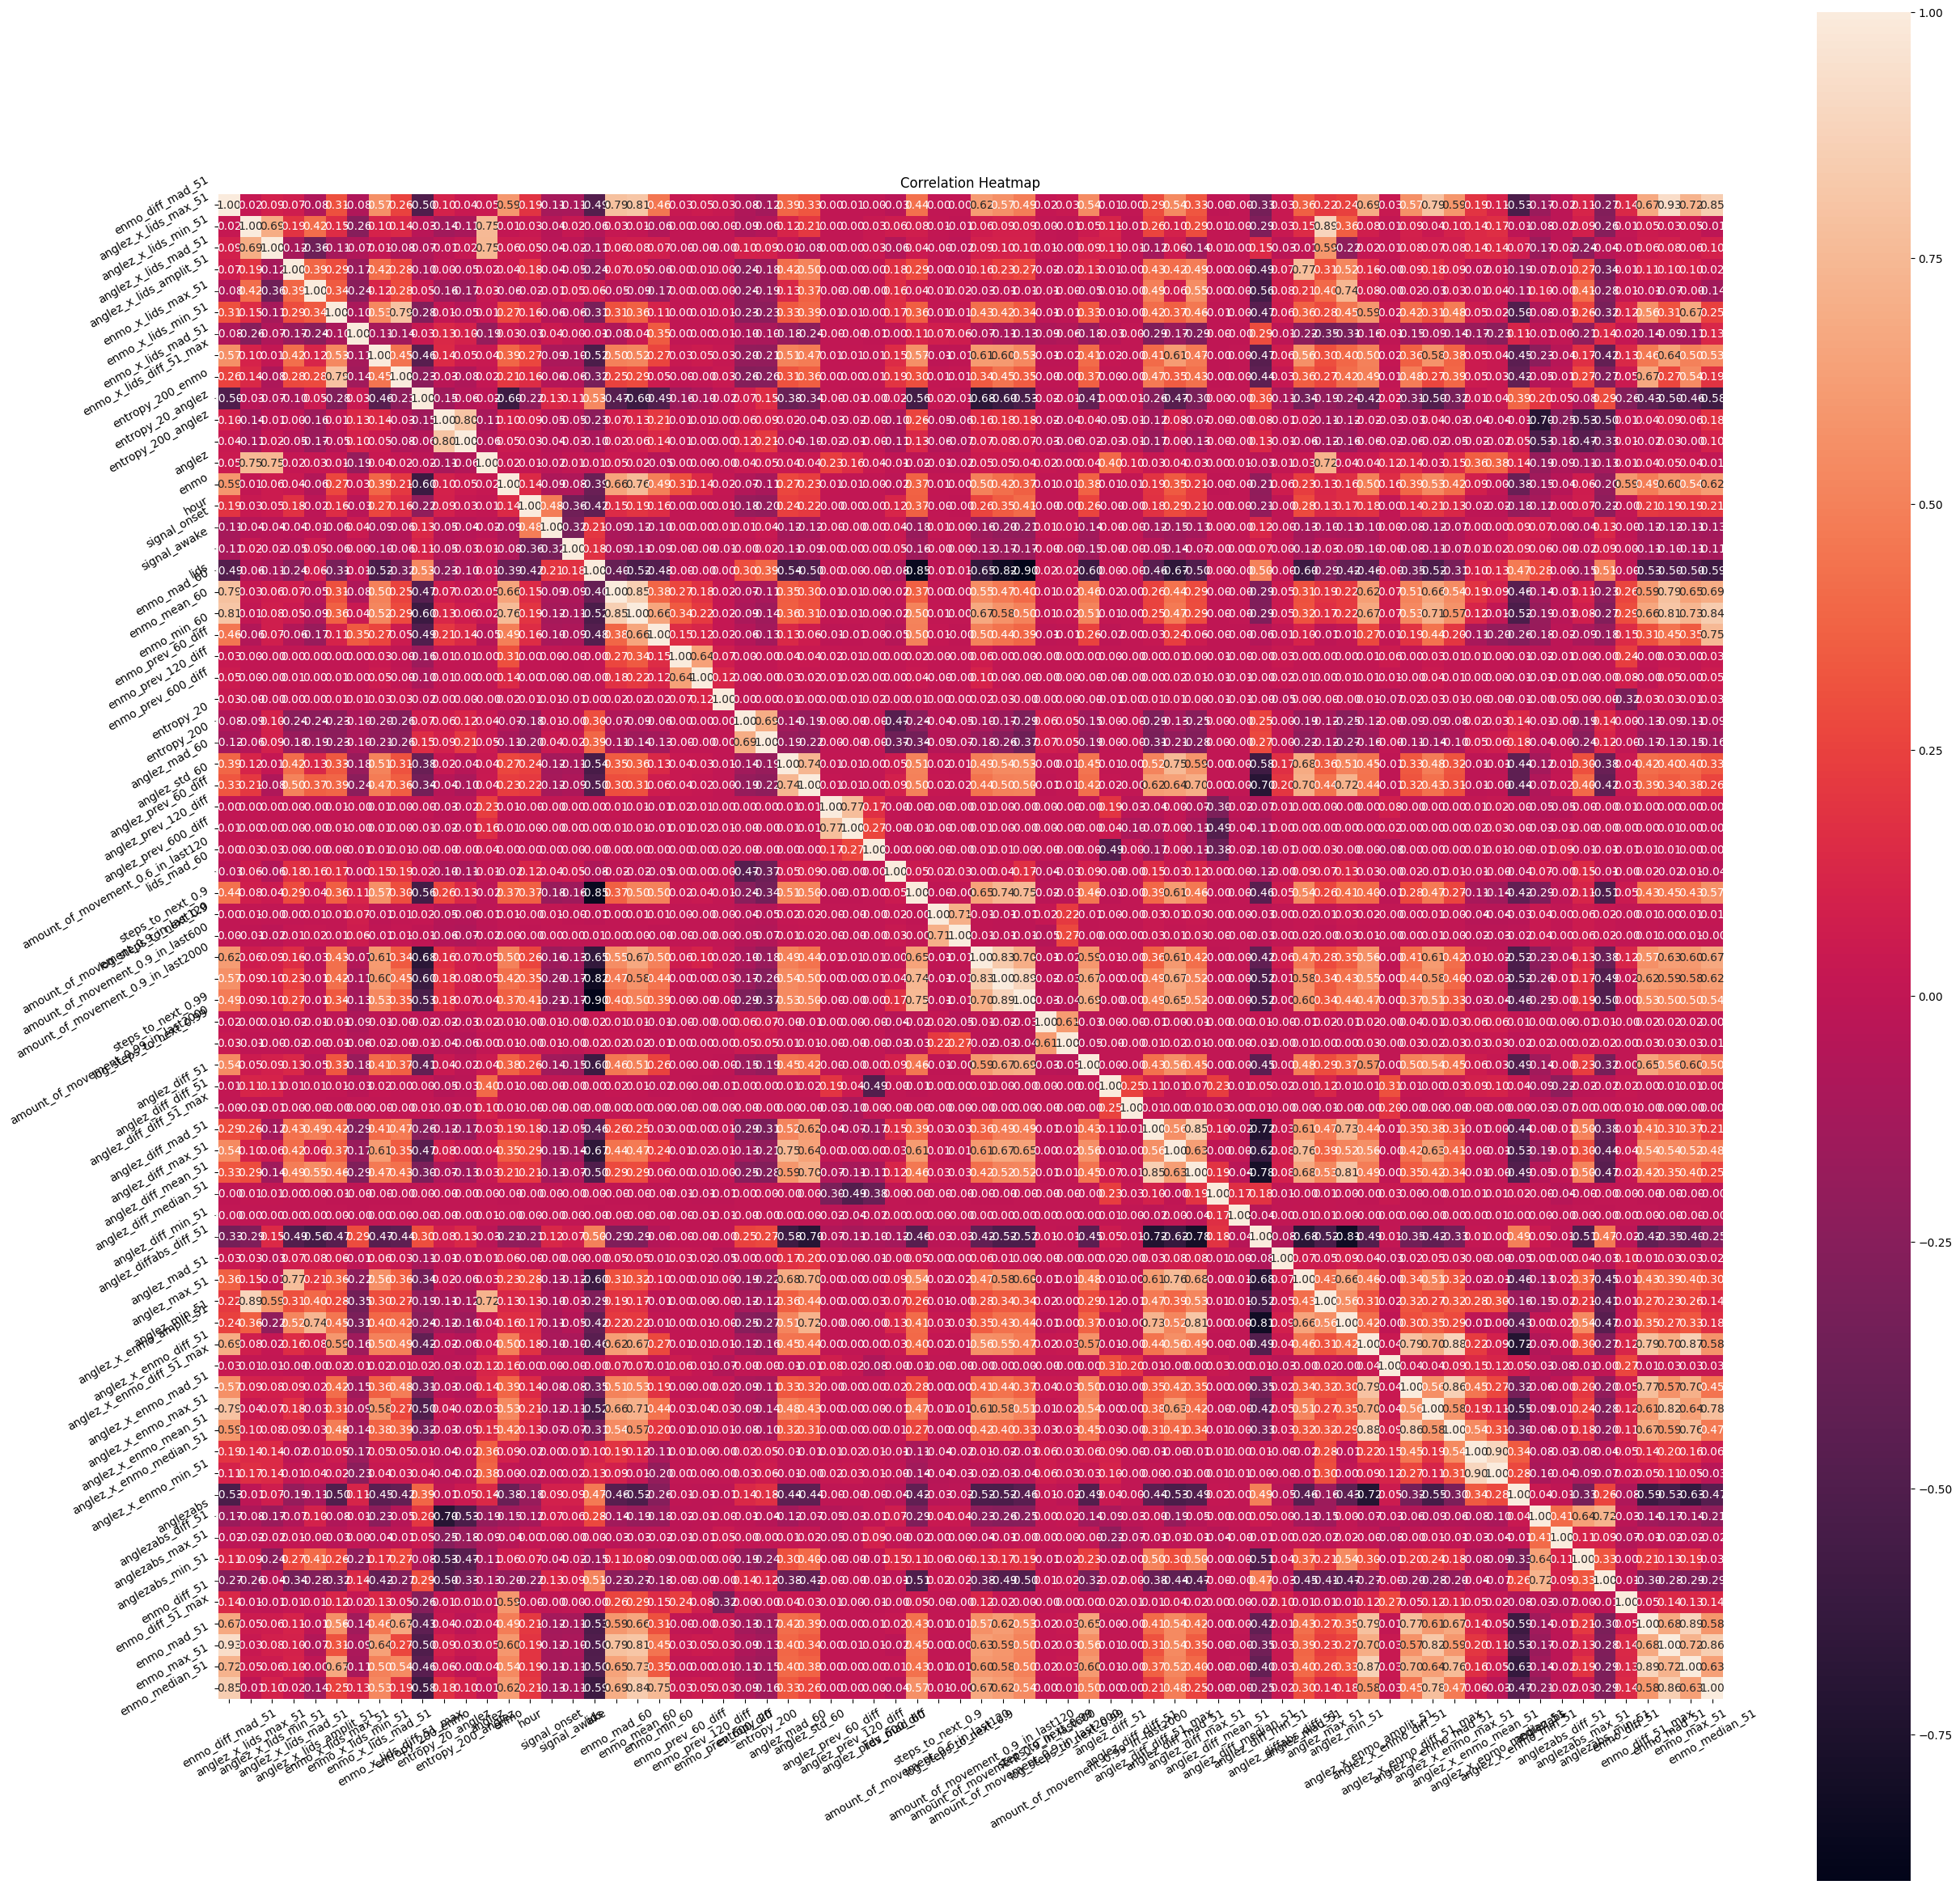

In [6]:
plt.figure(figsize=(30,30))
plt.title('Correlation Heatmap')
a = sns.heatmap(corr_matrix, square=True, annot=True, fmt='.2f', linecolor='black')
a.set_xticklabels(a.get_xticklabels(), rotation=30)
a.set_yticklabels(a.get_yticklabels(), rotation=30)           
plt.show()

In [7]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print(to_drop)

['enmo_mad_51']


In [8]:
X.drop(columns = to_drop, inplace = True)

<font size ="5"> Mutual Information </font> (Keep about 50 columns)

In [9]:
information = mutual_info_classif(X, y)

<Axes: >

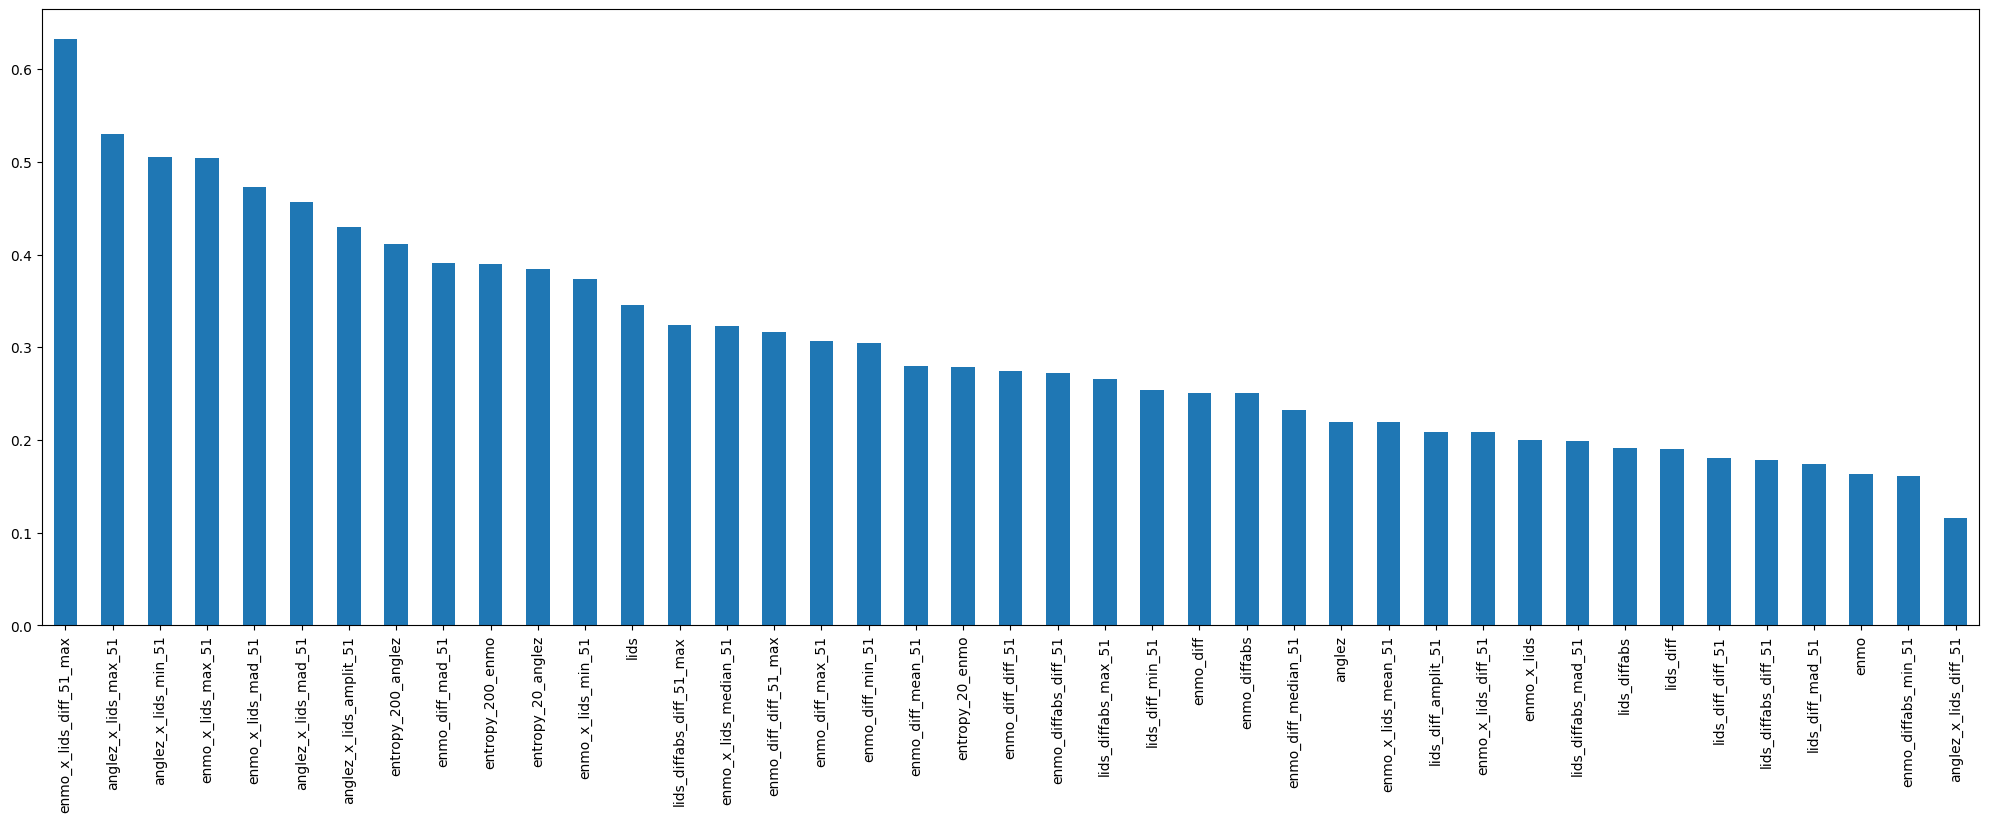

In [14]:
mutual_info = pd.Series(information)
mutual_info.index = X.columns
mutual_info.sort_values(ascending=False).plot.bar(figsize=(25, 8))

In [15]:
to_drop = mutual_info.sort_values(ascending=False).index[12:].tolist()
print(to_drop)

['lids', 'lids_diffabs_diff_51_max', 'enmo_x_lids_median_51', 'enmo_diff_diff_51_max', 'enmo_diff_max_51', 'enmo_diff_min_51', 'enmo_diff_mean_51', 'entropy_20_enmo', 'enmo_diff_diff_51', 'enmo_diffabs_diff_51', 'lids_diffabs_max_51', 'lids_diff_min_51', 'enmo_diff', 'enmo_diffabs', 'enmo_diff_median_51', 'anglez', 'enmo_x_lids_mean_51', 'lids_diff_amplit_51', 'enmo_x_lids_diff_51', 'enmo_x_lids', 'lids_diffabs_mad_51', 'lids_diffabs', 'lids_diff', 'lids_diff_diff_51', 'lids_diffabs_diff_51', 'lids_diff_mad_51', 'enmo', 'enmo_diffabs_min_51', 'anglez_x_lids_diff_51']


In [16]:
X.drop(columns = to_drop, inplace = True)

In [ ]:
print(X.columns)

In [18]:
X.rename(columns = {'entropy_20':'entropy_20_lids','entropy_200':'entropy_200_lids',
                      'amount_of_movement_0.6_in_last120':'amount_of_movement_0.6_in_last_120',
                     'amount_of_movement_0.9_in_last120': 'amount_of_movement_0.9_in_last_120',
                     'amount_of_movement_0.9_in_last600': 'amount_of_movement_0.9_in_last_600',
                    'amount_of_movement_0.9_in_last2000': 'amount_of_movement_0.9_in_last_2000',
                    'amount_of_movement_0.99_in_last2000' :'amount_of_movement_0.99_in_last_2000'
                    }, inplace = True)

In [23]:
X.columns.sort_values()

Index(['amount_of_movement_0.6_in_last_120',
       'amount_of_movement_0.99_in_last_2000',
       'amount_of_movement_0.9_in_last_120',
       'amount_of_movement_0.9_in_last_2000',
       'amount_of_movement_0.9_in_last_600', 'anglez', 'anglez_diff_51',
       'anglez_diff_diff_51', 'anglez_diff_diff_51_max', 'anglez_diff_mad_51',
       'anglez_diff_max_51', 'anglez_diff_mean_51', 'anglez_diff_median_51',
       'anglez_diff_min_51', 'anglez_diffabs_diff_51', 'anglez_mad_51',
       'anglez_mad_60', 'anglez_max_51', 'anglez_min_51',
       'anglez_prev_120_diff', 'anglez_prev_600_diff', 'anglez_prev_60_diff',
       'anglez_std_60', 'anglez_x_enmo_amplit_51', 'anglez_x_enmo_diff_51',
       'anglez_x_enmo_diff_51_max', 'anglez_x_enmo_mad_51',
       'anglez_x_enmo_max_51', 'anglez_x_enmo_mean_51',
       'anglez_x_enmo_median_51', 'anglez_x_enmo_min_51',
       'anglez_x_lids_amplit_51', 'anglez_x_lids_mad_51',
       'anglez_x_lids_max_51', 'anglez_x_lids_min_51', 'anglezabs',
    

In [25]:
train.drop(columns = ['enmo_mad_51',"anglez_diff_diff_51","anglez_x_enmo_diff_51", "anglez_prev_120_diff", 
"anglez_prev_60_diff", "enmo_prev_60_diff", "amount_of_movement_0.9_in_last_120",
"enmo_prev_120_diff", "anglez_diff_mean_51", "enmo_diff_51"], inplace = True)

<font size ="5"> Random Forest Importance </font> 

In [4]:
#Undersample to make the process faster
sampling_strategy = {0:31000000,1:31000000,2:31000000} #Total values: 0:54.859.423, 1: 31.099.716, 2: 41.987.201 (Need large undersampling)
rus = RandomUnderSampler(random_state=42, sampling_strategy=sampling_strategy)
X, y = rus.fit_resample(train.drop(columns= ['series_id', 'step', 'timestamp','state']), train['state'])
gc.collect()
del train

Hyperparameter optimization

In [5]:
train_x, val_x, train_y, val_y = train_test_split(X,y, test_size=0.35)
dtrain = olgb.Dataset(train_x, label=train_y)
dval = olgb.Dataset(val_x, label=val_y)

In [5]:
best_booster = None
gbm = None

def objective(trial):

    params = {
        "objective": "multiclass",
        "metric": "multi_logloss",
        "num_class": 3,
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        'max_depth':trial.suggest_int("max_depth", 4, 15),
    }
    global gbm
    gbm = lgb.train(
        params,
        dtrain,
        valid_sets=[dval],
        callbacks=[early_stopping(100), log_evaluation(100)],
    )
    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(valid_y, pred_labels)
    return accuracy
    
def callback(study, trial):
    global best_booster
    if study.best_trial == trial:
        best_booster = gbm

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20,n_jobs = -1, callbacks=[callback])

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
params = {
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_class": 3,
    "verbosity": -1,
    "boosting_type": "gbdt",
    "num_threads ": multiprocessing.cpu_count(),    
}

model = olgb.train(
    params,
    dtrain,
    valid_sets=[dval],
    callbacks=[early_stopping(200), log_evaluation(200)],
    model_dir="",
    num_boost_round = 2000
)

best_params = model.params
for key, value in best_params.items():
        print("    {}: {}".format(key, value))

In [4]:
lgb_params = {    
    'boosting_type':'gbdt',
    'num_leaves':31,
    'max_depth':5,
    'learning_rate':0.01,
    'n_estimators':100,
    'subsample_for_bin':200000,
    'min_child_weight':0.001,
    'min_child_samples':20,
    'subsample':0.6,
#     'colsample_bytree':0.7,
    'reg_alpha':0.05,
    'reg_lambda':0.05,
    'random_state':666,
    'n_jobs': multiprocessing.cpu_count(),
             }

    #'eval_metric': 'logloss',
    #'eval_set': []

In [ ]:
m = lgb.LGBMClassifier(**lgb_params)
m.fit(X,y)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.128631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13643
[LightGBM] [Info] Number of data points in the train set: 90000000, number of used features: 58
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


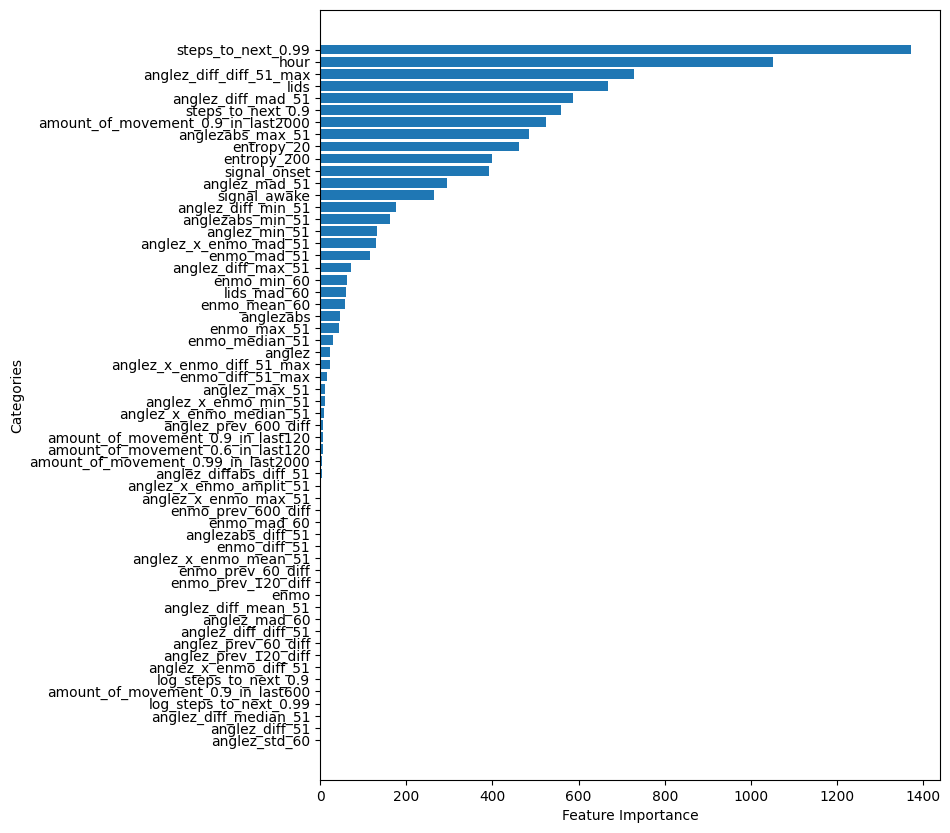

In [8]:
feat_imp = pd.Series(m.feature_importances_, index=X.columns).sort_values()
# Create a horizontal bar plot
plt.figure(figsize=(8, 10))  # Adjust the figure size as needed
plt.barh(feat_imp.index, feat_imp)

# Adding labels and a title
plt.xlabel('Feature Importance')
plt.ylabel('Categories')
plt.title('')

# Show the plot
plt.show()

In [ ]:
# save model
joblib.dump(m, 'lgb.pkl')

In [9]:
lgb = joblib.load('boosters/final.pkl')
print(lgb.params)
#train_x, val_x, train_y, val_y = train_test_split(X, y, test_size=0.25)
preds = lgb.predict(val_x)


{'objective': 'multiclass', 'metric': 'multi_logloss', 'num_class': 3, 'verbosity': -1, 'boosting_type': 'gbdt', 'num_threads ': 128, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 31, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000}


In [10]:
accuracy = sklearn.metrics.accuracy_score(val_y, np.argmax(preds, axis = 1))
print(accuracy)

0.9268105376344086


60


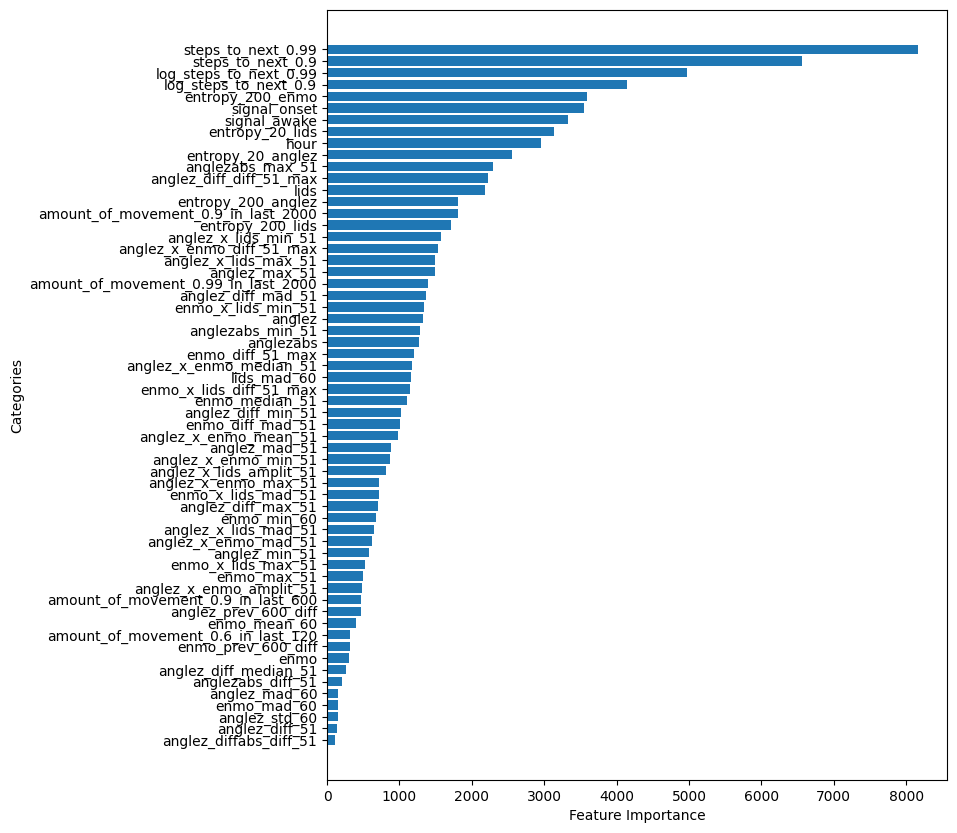

In [35]:
#Filter down based on percentile 
percentile = np.percentile(lgb.feature_importance(),0)
feat_imp = pd.Series(lgb.feature_importance(), index=train_x.columns).sort_values()
feat_imp.to_csv("feature_importances.csv", index = True)
#feat_imp = feat_imp[feat_imp>percentile]
print(len(feat_imp))
plt.figure(figsize=(8, 10))  # Adjust the figure size as needed
plt.barh(feat_imp.index, feat_imp)

# Adding labels and a title
plt.xlabel('Feature Importance')
plt.ylabel('Categories')
plt.title('')

# Show the plot
plt.show()